In [107]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
import pandas as pd

%matplotlib inline
np.random.seed(1)

Load Data

In [108]:
def load_happy_dataset():
    train_dataset = h5py.File('../datasets/train_happy.h5', 'r')
    train_set_x_og = np.array(train_dataset['train_set_x'][:])
    train_set_y_og = np.array(train_dataset['train_set_y'][:])

    test_dataset = h5py.File('../datasets/test_happy.h5', 'r')
    test_set_x_og = np.array(test_dataset['test_set_x'][:])
    test_set_y_og = np.array(test_dataset['test_set_y'][:])

    classes = np.array(test_dataset['list_classes'][:])

    train_set_y_og = train_set_y_og.reshape((1, train_set_y_og.shape[0]))
    test_set_y_og = test_set_y_og.reshape((1, test_set_y_og.shape[0]))

    return train_set_x_og, train_set_y_og, test_set_x_og, test_set_y_og, classes

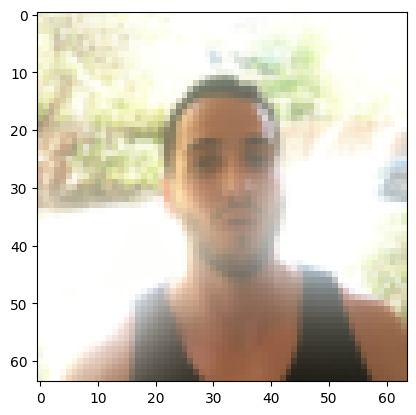

In [109]:
X_train_OG, Y_train_OG, X_test_OG, Y_test_OG, classes = load_happy_dataset()

X_train = X_train_OG/255.
X_test = X_test_OG/255.

Y_train = Y_train_OG.T
Y_test = Y_test_OG.T

index = 42
plt.imshow(X_train_OG[index])
plt.show()

Model using sequential API

In [110]:
def sequential_model():
    model = tf.keras.Sequential([
        tf.keras.layers.ZeroPadding2D(padding=(3, 3), input_shape=(64, 64, 3), data_format="channels_last"),
        tf.keras.layers.Conv2D(32, (7, 7), strides=(1, 1), name='conv0'),
        tf.keras.layers.BatchNormalization(axis=3, name='bn0'),
        tf.keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0),
        tf.keras.layers.MaxPooling2D((2, 2), name='max_pool0'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid', name='fc')
    ])
    return model

sqm = sequential_model()
sqm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
sqm.fit(X_train, Y_train, epochs=50, batch_size=32)

Epoch 1/50
19/19 [==============================] - 1s 8ms/step - loss: 2.4544 - accuracy: 0.5883
Epoch 2/50
19/19 [==============================] - 0s 8ms/step - loss: 0.3521 - accuracy: 0.8467
Epoch 3/50
19/19 [==============================] - 0s 8ms/step - loss: 0.1821 - accuracy: 0.9267
Epoch 4/50
19/19 [==============================] - 0s 7ms/step - loss: 0.1478 - accuracy: 0.9417
Epoch 5/50
19/19 [==============================] - 0s 6ms/step - loss: 0.1349 - accuracy: 0.9517
Epoch 6/50
19/19 [==============================] - 0s 7ms/step - loss: 0.0988 - accuracy: 0.9700
Epoch 7/50
19/19 [==============================] - 0s 7ms/step - loss: 0.0724 - accuracy: 0.9800
Epoch 8/50
19/19 [==============================] - 0s 8ms/step - loss: 0.1213 - accuracy: 0.9550
Epoch 9/50
19/19 [==============================] - 0s 7ms/step - loss: 0.1013 - accuracy: 0.9667
Epoch 10/50
19/19 [==============================] - 0s 7ms/step - loss: 0.1118 - accuracy: 0.9633
Epoch 11/50
19/19 [

Model using Functional API

In [112]:
def functional_model(input_shape):
    input_img = tf.keras.Input(input_shape)
    ## CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z1 = tf.keras.layers.Conv2D(filters=8, kernel_size=(4, 4), strides=(1, 1), padding='same')(input_img)
    ## RELU
    A1 = tf.keras.layers.ReLU()(Z1)
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.keras.layers.MaxPooling2D(pool_size=(8, 8), strides=(8, 8), padding='same')(A1)
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tf.keras.layers.Conv2D(filters=16, kernel_size=(2, 2), strides=(1, 1), padding='same')(P1)
    ## RELU
    A2 = tf.keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(Z2)
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(A2)
    ## FLATTEN
    F = tf.keras.layers.Flatten()(P2)
    ## Dense layer
    outputs = tf.keras.layers.Dense(units=6, activation='softmax')(F)

    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

conv_model = functional_model((64, 64, 3))

Train the model

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation=test_dataset)

Plot loss graph

In [ ]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')